In [493]:
import pandas as pd 
import statsmodels.tsa as tsa
import statsmodels.api as sm
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

In [494]:
data=pd.read_csv('tampa_with_pirates.csv')

#defining date_received as a datetime field in pandas
data['date_received'] = pd.to_datetime(data['date_received'])

#Defining date_received as index
data.index=data['date_received']
data.columns

Index(['date_received', 'citizen_init_count', 'officer_init_count',
       'year_received', 'month_received', 'week_received', 'day_received',
       'dow_received', 'AWND', 'FMTM', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG',
       'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03',
       'WT04', 'WT08', 'WT13', 'WT14', 'WT16', 'WT21', 'AWND_ln',
       'AWND_quartile', 'AWND_binary', 'PRCP_ln', 'PRCP_quartile',
       'PRCP_binary', 'SNOW_ln', 'SNOW_quartile', 'SNOW_binary', 'SNWD_ln',
       'SNWD_quartile', 'SNWD_binary', 'TAVG_ln', 'TAVG_quartile',
       'TAVG_binary', 'TMAX_ln', 'TMAX_quartile', 'TMAX_binary', 'TMIN_ln',
       'TMIN_quartile', 'TMIN_binary', 'WDF2_ln', 'WDF2_quartile',
       'WDF2_binary', 'WDF5_ln', 'WDF5_quartile', 'WDF5_binary', 'WSF2_ln',
       'WSF2_quartile', 'WSF2_binary', 'WSF5_ln', 'WSF5_quartile',
       'WSF5_binary', 'count', 'pirate_day', 'christmas', 'thanksgiving_13',
       'thanksgiving_12', 'thanksgiving', 'bin_PRCP'],
     

In [495]:
#Creating constant column for model intercept
data['constant']=1

#Dummy Variable for DOW
dow_dummies=pd.get_dummies(data['dow_received'], prefix='dow')
data=data.join(dow_dummies, how='left')


In [496]:
#Fitting GLM model
mod = sm.OLS(data['citizen_init_count'], data[['constant','dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5' ,'TMAX_ln', 'pirate_day']])
reg =mod.fit()

In [497]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:     citizen_init_count   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     47.45
Date:                Thu, 17 Sep 2015   Prob (F-statistic):           1.93e-61
Time:                        15:45:54   Log-Likelihood:                -3621.0
No. Observations:                 731   AIC:                             7260.
Df Residuals:                     722   BIC:                             7301.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
constant   -7927.8926    699.535    -11.333      0.0

In [498]:
#Creating dataframe for timeseries portion fitting
for_ts=pd.DataFrame()
for_ts['glm_resid']=reg.resid
for_ts['count']=data['citizen_init_count']
for_ts['glm_value']=reg.fittedvalues
for_ts['week']=data['week_received']
for_ts['month']=data['month_received']
for_ts['year']=data['year_received']

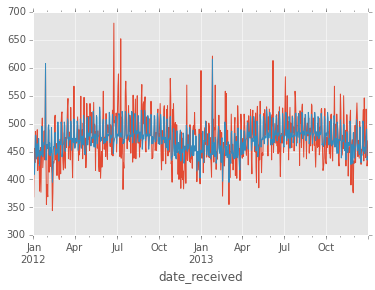

In [499]:
#Predicted glm vs. actuals
for_ts['count'].plot()
for_ts['glm_value'].plot()

In [500]:
#Fitting (1,1) ARMA Model on ARMA residuals
ts_model = tsa.arima_model.ARMA(for_ts['glm_resid'], (1,1))
ts_model_fit=ts_model.fit()

In [501]:
ts_model_fit.params

const              0.044744
ar.L1.glm_resid    0.572933
ma.L1.glm_resid   -0.402527
dtype: float64

In [502]:
#Adding ARMA model outputs to df
for_ts['ts_value']=ts_model_fit.fittedvalues
#for_ts['ts_resid']=ts_model_fit.resid

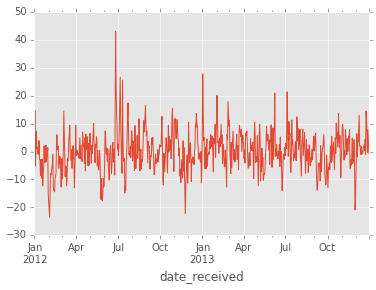

In [503]:
#Plot of AMRA Adjustments
for_ts['ts_value'].plot()

In [504]:
#final prediction and final error
for_ts['final_prediction']=for_ts['glm_value']+for_ts['ts_value']
for_ts['final_resid']=for_ts['count']-for_ts['final_prediction']

In [505]:
#Daily MAPEs
for_ts['glm_mape']=abs((for_ts['count']-for_ts['glm_value'])/for_ts['count'])
for_ts['final_mape']=abs((for_ts['count']-for_ts['final_prediction'])/for_ts['count'])

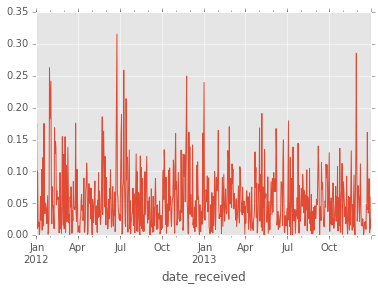

In [506]:
for_ts['glm_mape'].plot()


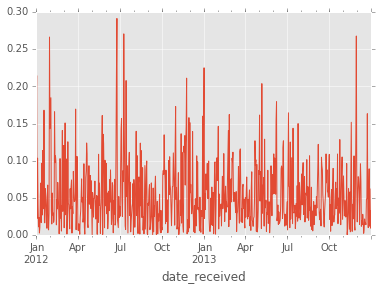

In [507]:
for_ts['final_mape'].plot()

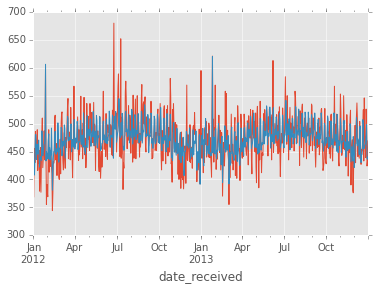

In [508]:
#Actuals vs. predicted
for_ts['count'].plot()
for_ts['final_prediction'].plot()


In [509]:
#MAPE after GLM
sum(for_ts['glm_mape'])/len(for_ts['glm_mape'])*100

5.484166513350667

In [510]:
#MAPE after GLM + ARMA
sum(for_ts['final_mape'])/len(for_ts['glm_mape'])*100

5.4231954468745576

In [511]:
sorted_df=for_ts.sort('final_mape', ascending=False)

In [512]:
#Days model was worst on
sorted_df[0:20]

,glm_resid,count,glm_value,week,month,year,ts_value,final_prediction,final_resid,glm_mape,final_mape
date_received,,,,,,,,,,,
2012-06-25,214.362755,680,465.637245,26,6,2012,16.289754,481.926999,198.073001,0.315239,0.291284
2012-07-10,168.637640,652,483.362360,28,7,2012,-7.794565,475.567795,176.432205,0.258647,0.270602
2013-11-29,-107.258036,376,483.258036,48,11,2013,-6.589530,476.668506,-100.668506,0.285261,0.267735
2012-01-30,-93.176791,355,448.176791,5,1,2012,1.378177,449.554968,-94.554968,0.262470,0.266352
2013-01-01,142.517760,595,452.482240,1,1,2013,8.659641,461.141881,133.858119,0.239526,0.224972
2012-06-24,115.503146,562,446.496854,25,6,2012,-8.475636,438.021218,123.978782,0.205522,0.220603
2012-01-02,-64.209243,368,432.209243,1,1,2012,14.733276,446.942519,-78.942519,0.174482,0.214518
2012-11-24,-95.534535,383,478.534535,47,11,2012,-14.684888,463.849647,-80.849647,0.249437,0.211096
2012-07-15,-81.795602,382,463.795602,28,7,2012,-2.403964,461.391639,-79.391639,0.214125,0.207832


In [513]:
#Days model was best on
sorted_df[-20:]

,glm_resid,count,glm_value,week,month,year,ts_value,final_prediction,final_resid,glm_mape,final_mape
date_received,,,,,,,,,,,
2013-01-22,6.485308,443,436.514692,4,1,2013,5.601512,442.116204,0.883796,0.014640,0.001995
2012-02-20,1.703937,446,444.296063,8,2,2012,0.830784,445.126847,0.873153,0.003820,0.001958
2012-09-22,-5.295384,508,513.295384,38,9,2012,-4.340487,508.954897,-0.954897,0.010424,0.001880
2012-08-23,-2.771526,471,473.771526,34,8,2012,-3.656231,470.115296,0.884704,0.005884,0.001878
2012-11-25,-22.907210,406,428.907210,47,11,2012,-22.171531,406.735678,-0.735678,0.056422,0.001812
2012-08-14,-0.116474,487,487.116474,33,8,2012,0.653649,487.770124,-0.770124,0.000239,0.001581
2012-03-08,-9.703248,462,471.703248,10,3,2012,-8.974493,462.728755,-0.728755,0.021003,0.001577
2012-12-30,-10.683206,392,402.683206,52,12,2012,-11.298351,391.384855,0.615145,0.027253,0.001569
2013-01-26,5.618604,621,615.381396,4,1,2013,4.706278,620.087674,0.912326,0.009048,0.001469


In [514]:
#Aggregating predictions up to weekly level
weekly_df=for_ts.groupby(by=['year', 'week']).sum()
weekly_df['glm_mape']=abs((weekly_df['count']-weekly_df['glm_value'])/weekly_df['count'])
weekly_df['final_mape']=abs((weekly_df['count']-weekly_df['final_prediction'])/weekly_df['count'])

In [515]:
#GLM MAPE
sum(weekly_df['glm_mape'])/len(weekly_df['glm_mape'])*100


2.5566933707834654

In [516]:
#Full MAPE
sum(weekly_df['final_mape'])/len(weekly_df['glm_mape'])*100

1.9865944102339668

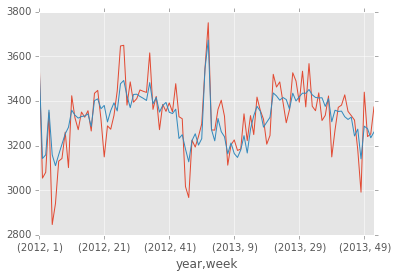

In [517]:
weekly_df['count'].plot()
weekly_df['final_prediction'].plot()

In [518]:
#Aggregating predictions up to monthly level
month_df=for_ts.groupby(by=['year', 'month']).sum()
month_df['glm_mape']=abs((month_df['count']-month_df['glm_value'])/month_df['count'])
month_df['final_mape']=abs((month_df['count']-month_df['final_prediction'])/month_df['count'])

In [519]:
#GLM MAPE
sum(month_df['glm_mape'])/len(month_df['glm_mape'])*100

1.6327490578081454

In [520]:
#Full Mape
sum(month_df['final_mape'])/len(month_df['glm_mape'])*100

1.2476129619273391

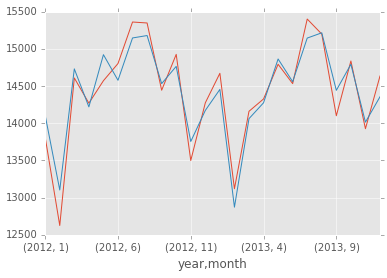

In [521]:
month_df['count'].plot()
month_df['final_prediction'].plot()